<font size=5>**Assignment for Spatial data scientist position 2023/05.**<font>

# Imports

In [1]:
# Add the path to the packages. 
# Please modify according to the local settings.

import sys
sys.path.append(r"...\my_env\Lib\site-packages")

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import rasterio
from rasterio.mask import mask

In [3]:
from watermark import watermark
print(watermark())

Last updated: 2023-10-17T19:12:07.281940+02:00

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 8.4.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores   : 8
Architecture: 64bit



# Settings and paths

In [4]:
# Input
gaul_path          = r".\data\GAUL\g2015_2005_2.shp"
nue_path           = r".\data\NUE_Zhang_et_al_2015\Country_NUE_assumption.csv"
wheat_harvest_path = r".\data\SPAM_2005_v3.2\SPAM2005V3r2_global_H_TA_WHEA_A.tif"
wheat_yield_path   = r".\data\SPAM_2005_v3.2\SPAM2005V3r2_global_Y_TA_WHEA_A.tif"


# Output
wheat_production_path   = r".\output\SPAM2005V3r2_global_P_TA_WHEA_A.tif"
country_production_path = r".\output\wheat_production_country.csv"
n_yield_path            = r".\output\N_yield.tif"
top10_path              = r".\output\top10.csv"
top10_plot_path         = r".\output\top10_plot.pdf"

# Tasks

## Using SPAM raster data, produce a new raster at the same resolution, containing wheat production volume (in million tons Mt). Produce a global map and export the raster in a geotif format.

In [5]:
%%time

# Open rasters
src = rasterio.open(wheat_harvest_path)
wheat_harvest = src.read()

src = rasterio.open(wheat_yield_path)
wheat_yield = src.read()


# Calculate production volume = area harvested * yield (formula from https://mapspam.info/methodology/)
wheat_production = wheat_harvest * wheat_yield


# Convert production volume to million tons (Mt)
wheat_production = wheat_production/1000000000


# Adjust no-data before export
wheat_production[(np.isin(wheat_harvest, [src.nodata]) | np.isin(wheat_yield, [src.nodata]))] = np.nan


# Export to Tiff
output_meta = src.meta.copy()        
with rasterio.open(wheat_production_path, 'w', **output_meta) as dst:
    dst.write(wheat_production)
print(f"File saved to disk: {wheat_production_path}")

File saved to disk: .\output\SPAM2005V3r2_global_P_TA_WHEA_A.tif
CPU times: total: 219 ms
Wall time: 226 ms


<timed exec>:10: RuntimeWarning: overflow encountered in multiply


## Using the newly created raster and the GAUL shapefile of administrative borders, aggregate production to country level and export to a csv file.

In [6]:
%%time
# Open vector
gaul = gpd.read_file(gaul_path)

CPU times: total: 1min 34s
Wall time: 1min 34s


In [7]:
%%time

# Dissolve by country
gaul = gaul[["ADM0_NAME", "geometry"]]
countries = gaul.dissolve(by="ADM0_NAME", as_index=False)

print(countries.shape)
display(countries.head(3))

(273, 2)


,ADM0_NAME,geometry
0,Afghanistan,"POLYGON ((63.34748 29.45188, 63.34287 29.45295..."
1,Aksai Chin,"POLYGON ((79.38245 35.97878, 79.39043 35.97862..."
2,Albania,"MULTIPOLYGON (((19.83331 40.05114, 19.82395 40..."


CPU times: total: 8min 41s
Wall time: 8min 41s


In [8]:
%%time
# Extract raster values for each country
country_production = []

for i, country in countries.iterrows():
    
    geom = country.geometry
    
    with rasterio.open(wheat_production_path) as src:
         img, out_transform = mask(src, [geom], crop=True)
    
    aggregated = img[(img!=src.nodata) & ~np.isnan(img)].sum()
    
    country_production.append(aggregated)

CPU times: total: 2min 12s
Wall time: 2min 12s


In [9]:
# Prepare dataframe for export
country_production_df = pd.DataFrame(list(zip(countries["ADM0_NAME"], country_production)), 
                                     columns=["Country", "wheat_production_Mt"])
country_production_df = country_production_df.round(3)
display(country_production_df.head(3))

,Country,wheat_production_Mt
0,Afghanistan,3.353
1,Aksai Chin,0.000
2,Albania,0.248


In [10]:
# Export to csv
country_production_df.to_csv(country_production_path, index=False, float_format="%.2f")

## Using the raster of wheat production generated in question 1, and assuming that 2% of harvested wheat yield consists of nitrogen (N) element, create, plot and export a raster of N output in harvested wheat yield.

In [11]:
# Calculate N yield
n_yield = wheat_production*0.2

In [12]:
# Plot
plt.figure(figsize=(18, 10), dpi=900)
plt.imshow(np.squeeze(n_yield))
plt.colorbar(shrink=0.3)

In [13]:
# Export to tiff
with rasterio.open(n_yield_path, 'w', **output_meta) as dst:
    dst.write(n_yield)
print(f"File saved to disk: {n_yield_path}")

File saved to disk: .\output\N_yield.tif


## Using the dataset of country-level nitrogen use efficiency (NUE) of wheat from Zhang et al 2015, and steps from previous questions:
    a. estimate for the 10 biggest wheat producers the country-level values of N output in harvested wheat, as well as related total N inputs and N losses (i.e., surplus) and export the dataset as a csv file

In [14]:
# Pick top 10 wheat producers
top10 = country_production_df.sort_values(by="wheat_production_Mt", ascending=False).head(10)

# Read NUE dataset
nue = pd.read_csv(nue_path)

# Match country names before merging the tables
nue = nue.replace({"Country": "USA"}, {"Country": "United States of America"}, regex=True)
nue = nue.replace({"Country": "RussianFed"}, {"Country": "Russian Federation"}, regex=True)

# Merge tables
top10 = top10.merge(nue, on="Country")
top10.reset_index(inplace=True,drop=True)

# Add nitrogen indicators (based on ZHANG ET AL. 2015)
top10["N_yield"] = top10["wheat_production_Mt"]*0.2
top10["N_surplus"] = top10["N_yield"]*(1/top10["NUE"]+1)
top10["N_input"] = top10["N_yield"] + top10["N_surplus"]

# Round to 3 decimals
top10[top10.select_dtypes(np.float32).columns] = top10.select_dtypes(np.float32).astype(np.float64)
top10 = top10.round(3)

display(top10)

# Export to csv
top10.to_csv(top10_path, index=False, float_format="%.2f")

,Country,wheat_production_Mt,NUE,N_yield,N_surplus,N_input
0,China,99.265,0.262,19.853,95.522,115.375
1,India,69.558,0.250,13.912,69.576,83.487
2,United States of America,55.127,0.508,11.025,32.729,43.755
3,Russian Federation,46.022,0.619,9.204,24.079,33.284
4,France,37.273,0.742,7.455,17.503,24.958
5,Canada,25.264,0.503,5.053,15.090,20.143
6,Germany,23.818,0.459,4.764,15.151,19.914
7,Pakistan,20.897,0.200,4.179,25.093,29.272
8,Turkey,20.832,0.423,4.166,14.026,18.192
9,Australia,19.302,0.541,3.860,10.998,14.858


    b. visualize the N outputs and losses for these 10 countries in 1 summary figure (plot to be exported as pdf)

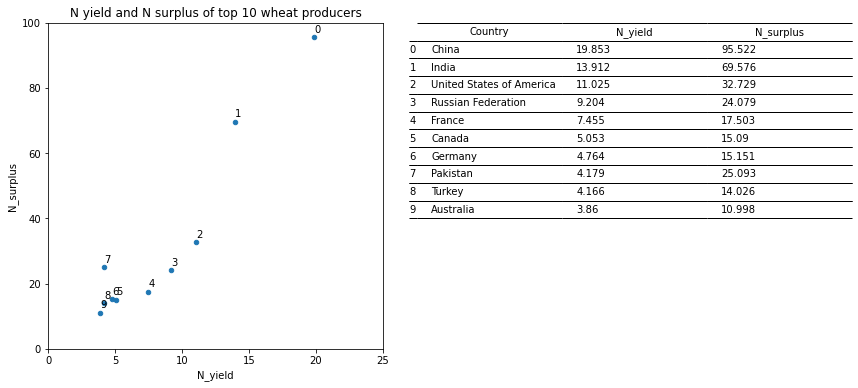

In [15]:
# Plot of N yield and N surplus

ax = top10.plot.scatter(x="N_yield", y="N_surplus", figsize=(6,6))
ax.set_xlim(0, 25)
ax.set_ylim(0, 100)
plt.title("N yield and N surplus of top 10 wheat producers")

for idx, row in top10.iterrows():
    ax.annotate(idx, (row['N_yield'], row['N_surplus']), xytext=(0,5),
                textcoords='offset points')
    
table = pd.plotting.table(ax, top10[['Country', 'N_yield', 'N_surplus']], 
                          cellLoc='left',
                          bbox=[1.1, 0.4, 1.3, 0.6], 
                          edges='horizontal'                          
                         )
table.auto_set_font_size(False)

# Export to pdf
plt.savefig(top10_plot_path, format="pdf", bbox_inches="tight")

    c. explain in 2-3 sentences the main patterns of N losses across countries, in relation to production volume and 
    NUE (including any singular feature).

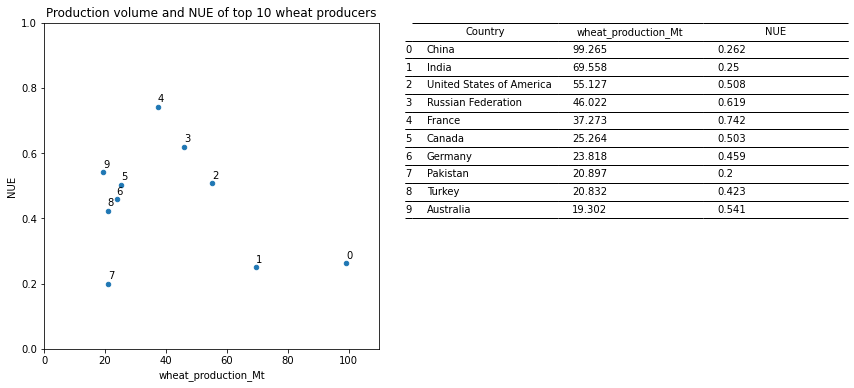

In [16]:
# Plot of wheat production volume and NUE

ax = top10.plot.scatter(x="wheat_production_Mt", y="NUE", figsize=(6,6))
ax.set_xlim(0, 110)
ax.set_ylim(0, 1)
plt.title("Production volume and NUE of top 10 wheat producers")

for idx, row in top10.iterrows():
    ax.annotate(idx, (row['wheat_production_Mt'], row['NUE']), xytext=(0,5), textcoords='offset points')
    
table = pd.plotting.table(ax, top10[['Country', 'wheat_production_Mt', 'NUE']], 
                          cellLoc='left',
                          bbox=[1.1, 0.4, 1.3, 0.6], 
                          edges='horizontal'                          
                         )
table.auto_set_font_size(False)